# Shadow removal with histogram equalization
This was the first (failed) try of removing shadow in image.
In this code, the approach was to detect the shadow regions by limiarizing the image according to the V layer from HSV color space, and removing theem by equalizing the histogram of colors linearly, ditributing the histogram in all uint8 values.

## Color space analysis
First of all, an analysis of the image was done to visualy select the best option of limiarizing the shadowed regions on scenario.
For this first step it was used the V (value) layer of HSV color space to find the shadowed regions on image.

In [1]:
# importing necessary libraries
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# readjustment of range of values
def range_adjustment(img,minvalue=0,maxvalue=255):
    try:
        layers = img.shape[2]
    except:
        layers = 1
    
    img_u8 = np.zeros(img.shape, dtype=np.uint8)
    if(layers > 1):
        for z in range(layers):
            currmin = np.min(img[:,:,z])
            currmax = np.max(img[:,:,z])
            for x in range(img.shape[0]):
                for y in range(img.shape[1]):
                    img_u8[x,y,z] = ((img[x,y,z]-currmin)*(maxvalue - minvalue)//(currmax - currmin)) + minvalue
    else:
        currmin = np.min(img)
        currmax = np.max(img)
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                img_u8[x,y] = ((img[x,y]-currmin)*(maxvalue - minvalue)//(currmax - currmin)) + minvalue
    
    return img_u8 

By ploting each RGB layers of the original image individually is possible to see that using them to limiarize the shadowed regions would be hard, as it was expected.

Text(0.5, 1.0, 'B')

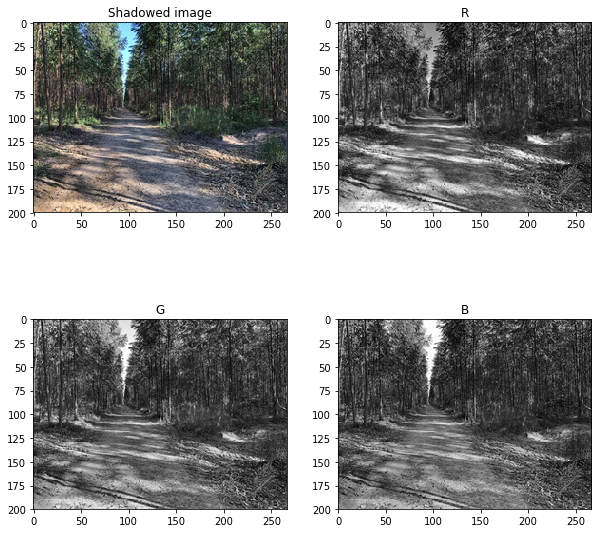

In [15]:
I = imageio.imread("../images/shadow5.jpg")
plt.figure(figsize=(10,10))
plt.subplot(221); plt.imshow(I); plt.title("Shadowed image")
plt.subplot(222); plt.imshow(I[:,:,0],cmap='gray'); plt.title("R")
plt.subplot(223); plt.imshow(I[:,:,1],cmap='gray'); plt.title("G")
plt.subplot(224); plt.imshow(I[:,:,2],cmap='gray'); plt.title("B")

On the other hand, for HSV colorspace, the V channel looks more feasable to be used as a shadow limiarizer, since it represents the luminance on image, independently of its chromaticity.

Text(0.5, 1.0, 'V')

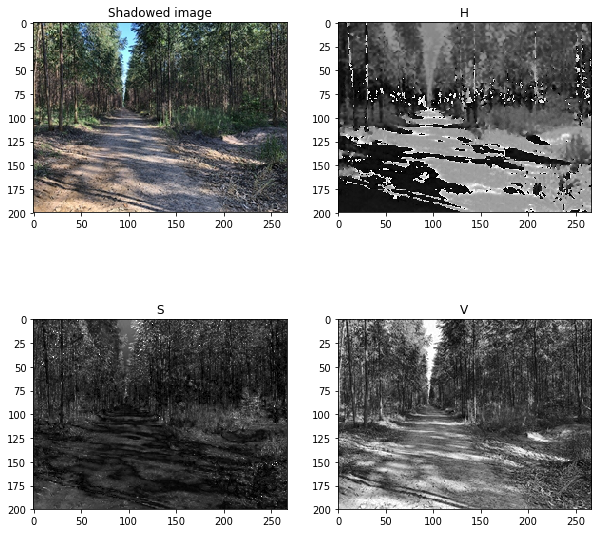

In [17]:
I_hsv = mpl.colors.rgb_to_hsv(I)
plt.figure(figsize=(10,10))
plt.subplot(221); plt.imshow(I); plt.title("Shadowed image")
plt.subplot(222); plt.imshow(range_adjustment(I_hsv[:,:,0],0,255),cmap='gray'); plt.title("H")
plt.subplot(223); plt.imshow(range_adjustment(I_hsv[:,:,1],0,255),cmap='gray'); plt.title("S")
plt.subplot(224); plt.imshow(range_adjustment(I_hsv[:,:,2],0,255),cmap='gray'); plt.title("V")

## Limiarization
Once the color space and layer were chosen, the next step was the limiarization.
The threshold value was defined emipiracally.

It is important to highlight that because of this empirical method of defining the thresholding level, this limiarization works only for some specific scenarios that approximates with the first image in which the value was defined.

In [5]:
def limiarization(img, thr = 0.5):
    threshold = thr * np.max(img)
    mask = np.zeros(img.shape, dtype = np.uint8)
    mask[np.where(img < threshold)] = 1
    return mask

The shadow regions found can be seen as white pixels.

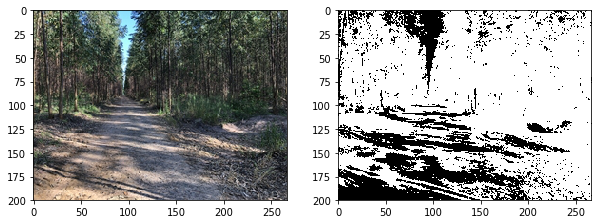

In [19]:
shadow_mask = limiarization(I_hsv[:,:,2],0.47)
plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(I)
plt.subplot(122); plt.imshow(shadow_mask, cmap="gray")

## The histogram equalization
After detecting the shadowed regions it is time to "remove" them by equalizing the histogram in these regions.
By doing that it was expected the shadowed became lighter.

In [7]:
def histogram(img, range_values):
    # creates an empty histogram array with size proportional to the number of pixel values 
    histogram = np.zeros(range_values).astype(int)

    # count every quantity of every value present in image
    for i in range(range_values):
        # locate all pixels with value i in a vector
        pix_i_values = np.where(img == i)
        
        # get quantity of pixels by the previous vector array length
        histogram[i] = pix_i_values[0].shape[0]
            
    return histogram

In [8]:
Rshadow = shadow_mask*I[:,:,0]
Gshadow = shadow_mask*I[:,:,1]
Bshadow = shadow_mask*I[:,:,2]

Rshadow_histogram = histogram(Rshadow[np.where(Rshadow>0)], 256)
Gshadow_histogram = histogram(Gshadow[np.where(Gshadow>0)], 256)
Bshadow_histogram = histogram(Bshadow[np.where(Bshadow>0)], 256)


In [9]:
def range_adjustment(img, minvalue=0, maxvalue=255):
    currmin = np.min(img)
    currmax = np.max(img)
    
    img_u8 = np.zeros(img.shape, dtype=np.uint8)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            img_u8[x,y] = ((img[x,y]-currmin)*(maxvalue - minvalue)//(currmax - currmin)) + minvalue
    
    return img_u8    

## Result and Discussion
Analysing the result of this method, the shadowed regions did become lighter, but not with correct colors.

<BarContainer object of 256 artists>

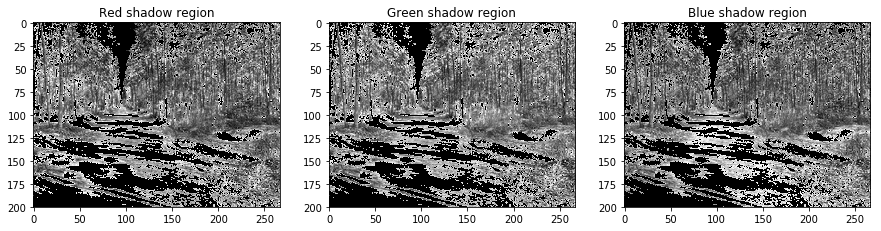

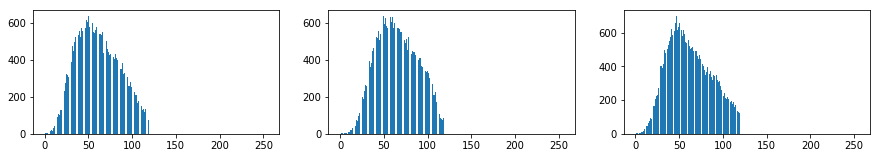

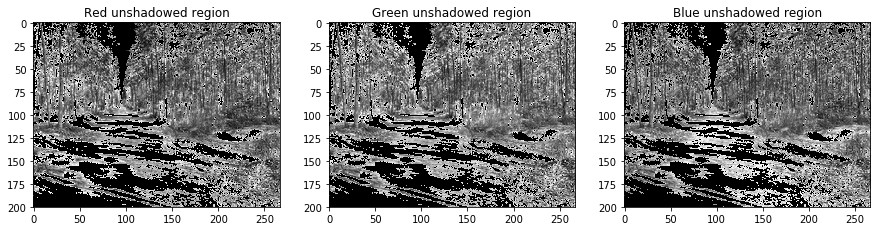

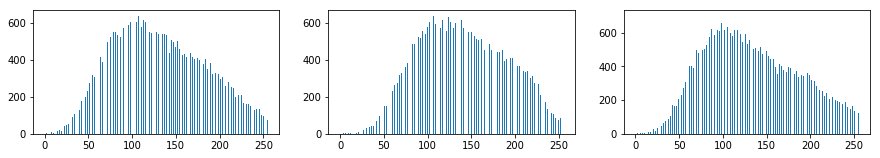

In [10]:
Runshadow = np.zeros(Rshadow.shape, dtype = np.uint8)
Gunshadow = np.zeros(Gshadow.shape, dtype = np.uint8)
Bunshadow = np.zeros(Bshadow.shape, dtype = np.uint8)

Runshadow =  range_adjustment(Rshadow, 0, 255)
Gunshadow =  range_adjustment(Gshadow, 0, 255)
Bunshadow =  range_adjustment(Bshadow, 0, 255)

Runshadow_histogram = histogram(Runshadow[np.where(Runshadow>0)], 256)
Gunshadow_histogram = histogram(Gunshadow[np.where(Gunshadow>0)], 256)
Bunshadow_histogram = histogram(Bunshadow[np.where(Bunshadow>0)], 256)

plt.figure(figsize=(15,10))
plt.subplot(231); plt.imshow(Rshadow, cmap='gray'); plt.title("Red shadow region")
plt.subplot(232); plt.imshow(Gshadow, cmap='gray'); plt.title("Green shadow region")
plt.subplot(233); plt.imshow(Bshadow, cmap='gray'); plt.title("Blue shadow region")
plt.figure(figsize=(15,5))
plt.subplot(234); plt.bar(range(256), Rshadow_histogram);
plt.subplot(235); plt.bar(range(256), Gshadow_histogram);
plt.subplot(236); plt.bar(range(256), Bshadow_histogram)
plt.figure(figsize=(15,10))
plt.subplot(231); plt.imshow(Runshadow, cmap='gray'); plt.title("Red unshadowed region")
plt.subplot(232); plt.imshow(Gunshadow, cmap='gray'); plt.title("Green unshadowed region")
plt.subplot(233); plt.imshow(Bunshadow, cmap='gray'); plt.title("Blue unshadowed region")
plt.figure(figsize=(15,5))
plt.subplot(234); plt.bar(range(256), Runshadow_histogram)
plt.subplot(235); plt.bar(range(256), Gunshadow_histogram)
plt.subplot(236); plt.bar(range(256), Bunshadow_histogram)

Text(0.5, 1.0, 'unshadowed region')

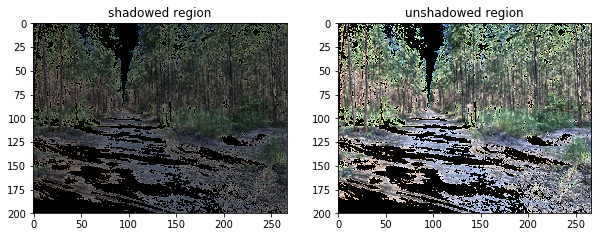

In [11]:
shadow = np.dstack((Rshadow, Gshadow, Bshadow))
unshadow = np.dstack((Runshadow, Gunshadow, Bunshadow))

plt.figure(figsize = (10,5))
plt.subplot(121); plt.imshow(shadow); plt.title("shadowed region")
plt.subplot(122); plt.imshow(unshadow); plt.title("unshadowed region")

If we crop the original image, leaving only the shadowed regions, it is clear the colors are different than expected; for example the shadows on the road are more like blue when the expected was to be more like brown/reddish.

If we plot the color histogram of the lit regions of the image, it is possible to see the diference between the unshadowed regions and the lit regions.

<BarContainer object of 256 artists>

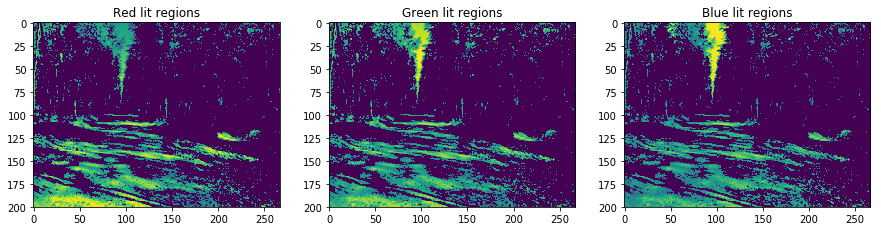

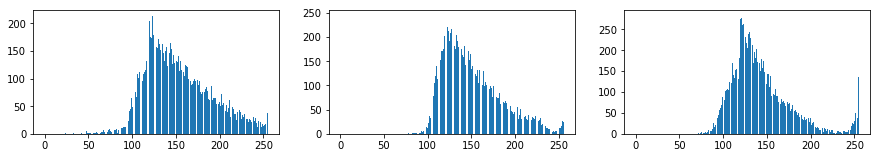

In [20]:
Rnonshadow = (1-shadow_mask)*I[:,:,0]
Gnonshadow = (1-shadow_mask)*I[:,:,1]
Bnonshadow = (1-shadow_mask)*I[:,:,2]

Rnonshadow_histogram = histogram(Rnonshadow[np.where(Rnonshadow>0)], 256)
Gnonshadow_histogram = histogram(Gnonshadow[np.where(Gnonshadow>0)], 256)
Bnonshadow_histogram = histogram(Bnonshadow[np.where(Bnonshadow>0)], 256)

plt.figure(figsize=(15,10))
plt.subplot(231); plt.imshow(Rnonshadow); plt.title("Red lit regions")
plt.subplot(232); plt.imshow(Gnonshadow); plt.title("Green lit regions")
plt.subplot(233); plt.imshow(Bnonshadow); plt.title("Blue lit regions")
plt.figure(figsize=(15,5))
plt.subplot(234); plt.bar(range(256), Rnonshadow_histogram)
plt.subplot(235); plt.bar(range(256), Gnonshadow_histogram)
plt.subplot(236); plt.bar(range(256), Bnonshadow_histogram)

Finally, joining the unshadowed and non-shadowed regions we have the final result.

In fact, this failed result was expected after analysing the histograms.
From here we know it is necessary not just separate the shadowed and lit regions, but also separate the regions according to their colors (green parts, ground, sky) and them treat these regions separately.

Text(0.5, 1.0, 'Result: unshadowed image')

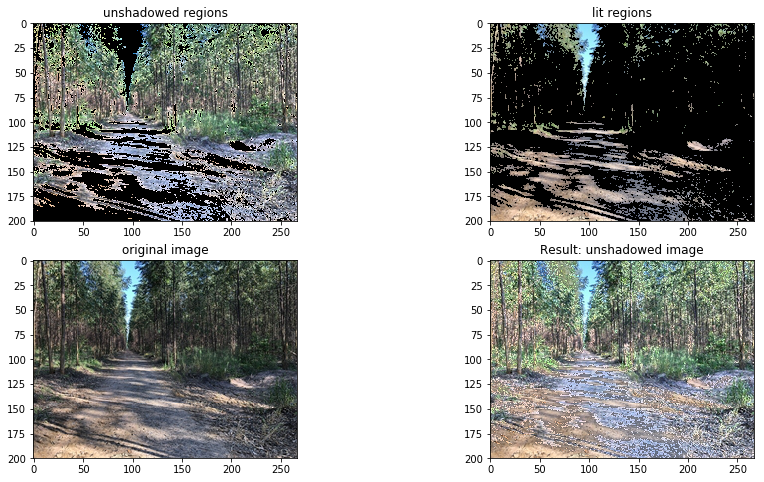

In [22]:
nonshadow = np.dstack((Rnonshadow, Gnonshadow, Bnonshadow))
Iunshadowed = unshadow + nonshadow

plt.figure(figsize=(15,8))
plt.subplot(221); plt.imshow(unshadow); plt.title("unshadowed regions")
plt.subplot(222); plt.imshow(nonshadow); plt.title("lit regions")
plt.subplot(223); plt.imshow(I); plt.title("original image")
plt.subplot(224); plt.imshow(Iunshadowed); plt.title("Result: unshadowed image")